# ML for Texts- Negative Review Detection

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [31]:
import math
import re
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from transformers import BertTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm.auto import tqdm

In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [33]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [34]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

### Ckecking Datatypes

In [35]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

The DataFrame  has 17 columns, with a mixture of categorical, discrete, and continuous variables. As we will be building a model to determine whether a review is positive or negative based on the content of the review itself, most of these features are irrelevant; as such, we do not need to concern ourselves with preprocessing anything other than the 'review' and 'pos' Series for our model. The datatype of the 'review' and 'pos' columns are object and int64, respectively. They are properly formatted for the purposes of training and testing machine learning models.

In [36]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

There is missing data in the 'average_rating' and 'votes' column. Since we will not be using these columns for the development of reviews, we will not adress this.

In [37]:
df_reviews.duplicated().sum()

0

## EDA

Let's check the number of movies and reviews over the years to better understand our data. We will begin by examining the total number of movies released and reviews created each year.

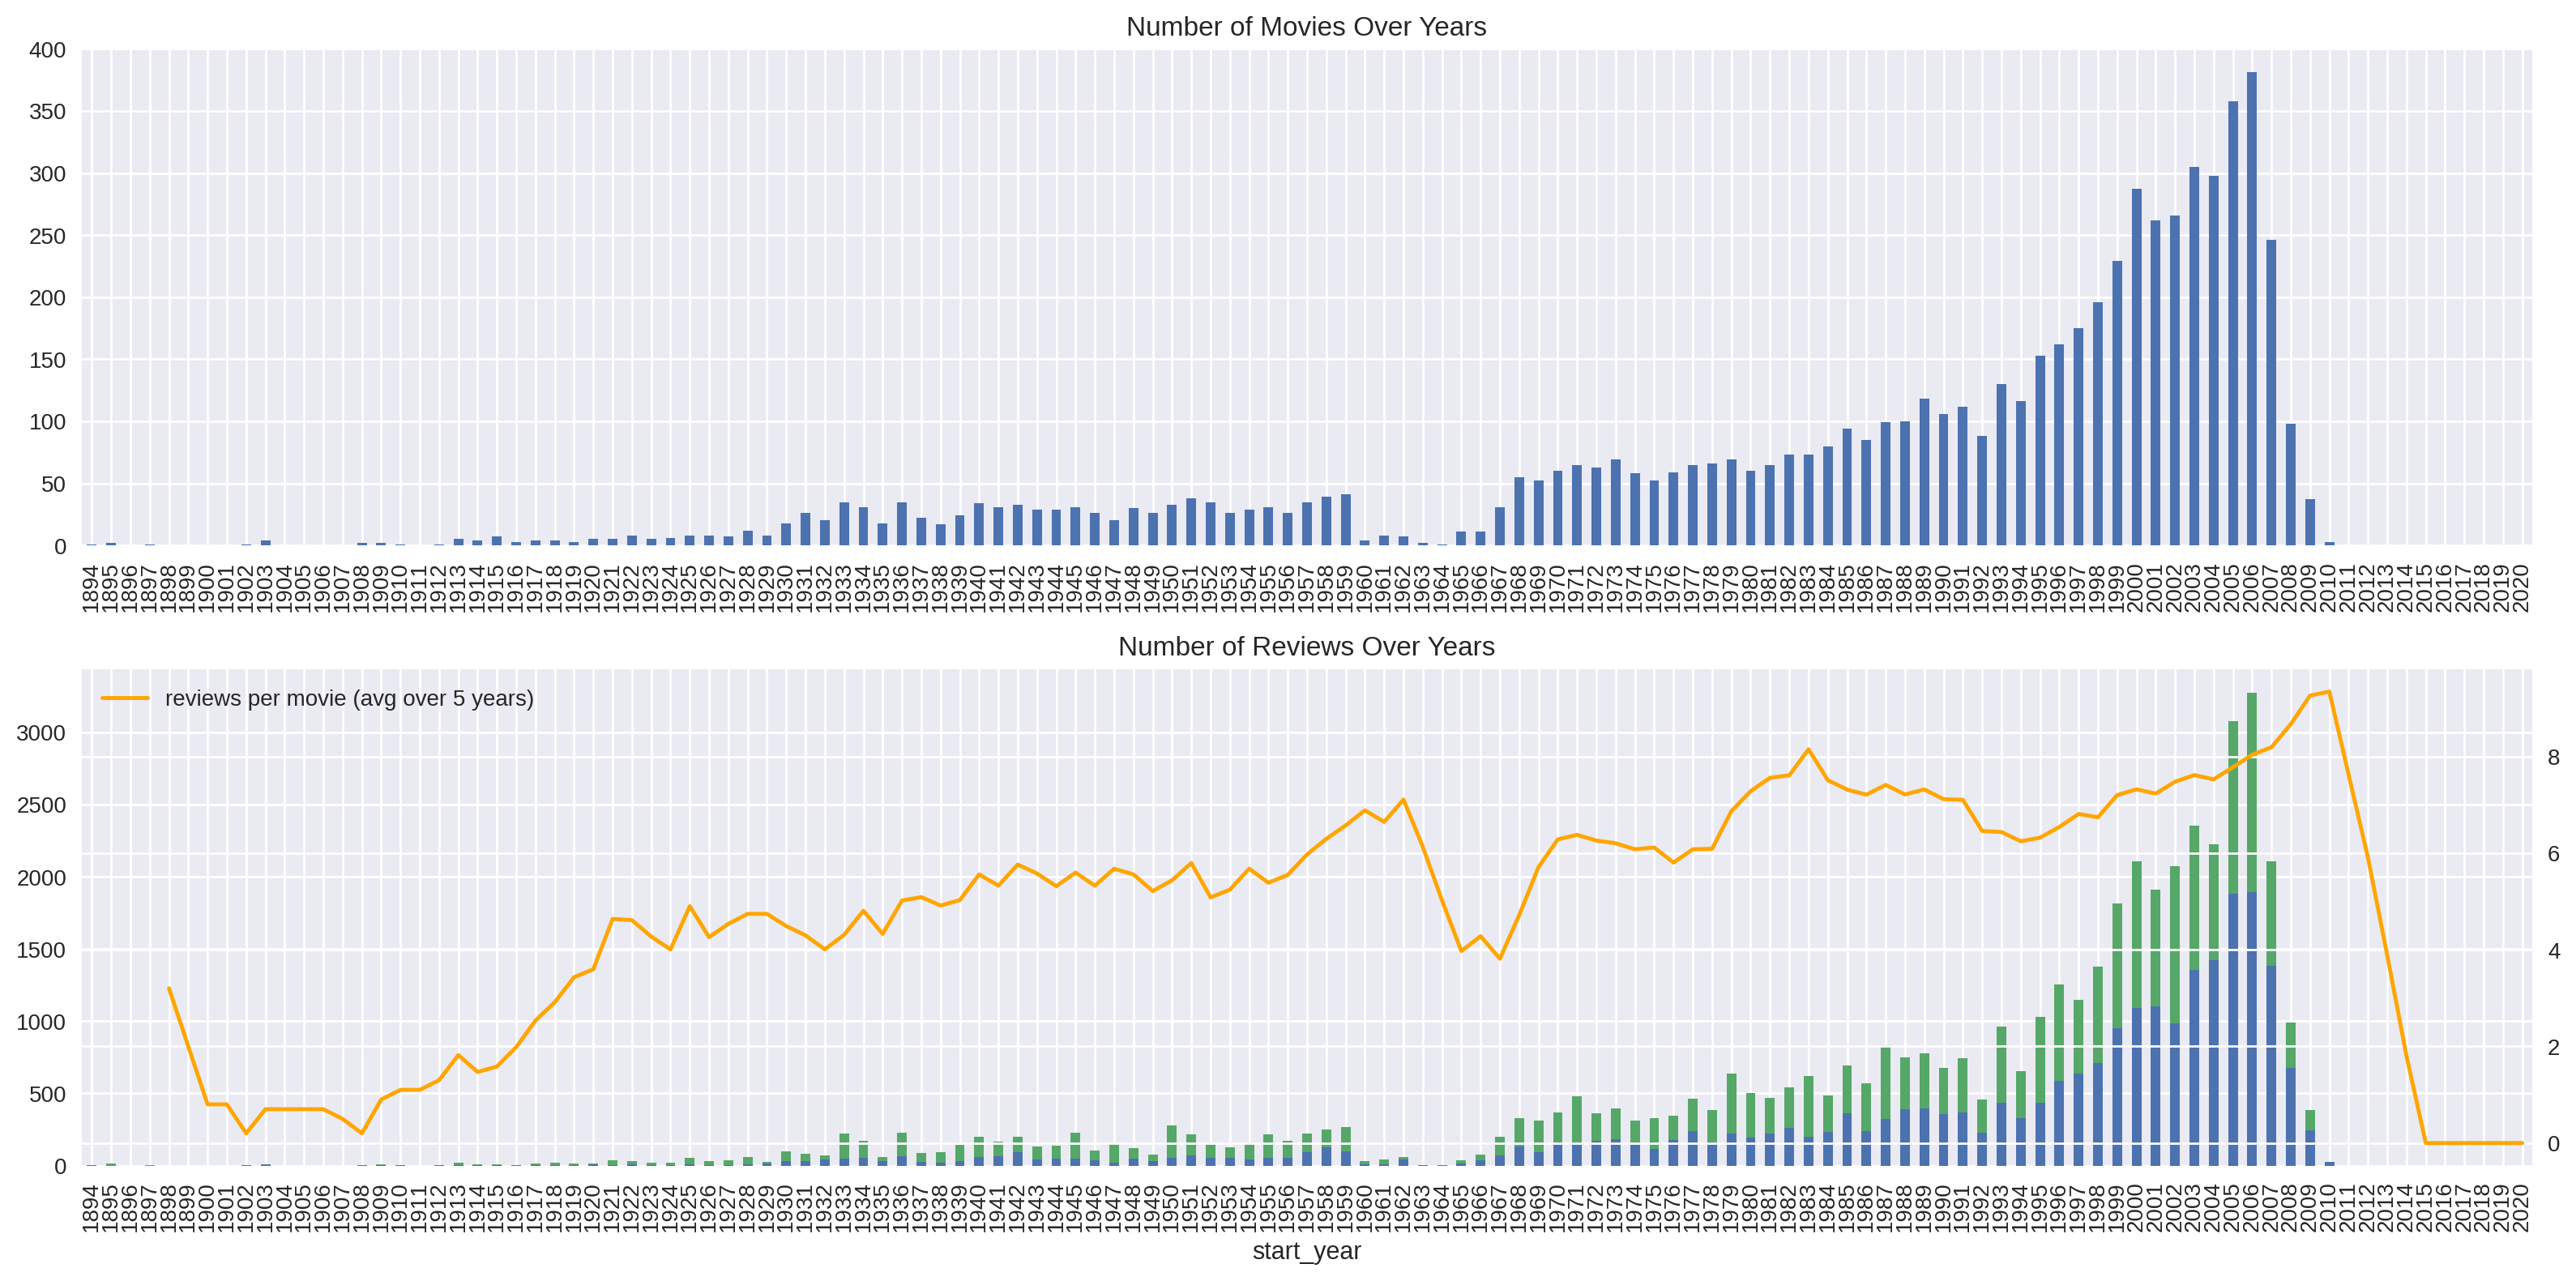

In [38]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The above graphs allow us to visualize the number of movies released and reviews made each year. Over the years the amount of reviews have been low untill about 1990. From then till 2006 there was a dramatic increase in number of reviews per movie.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

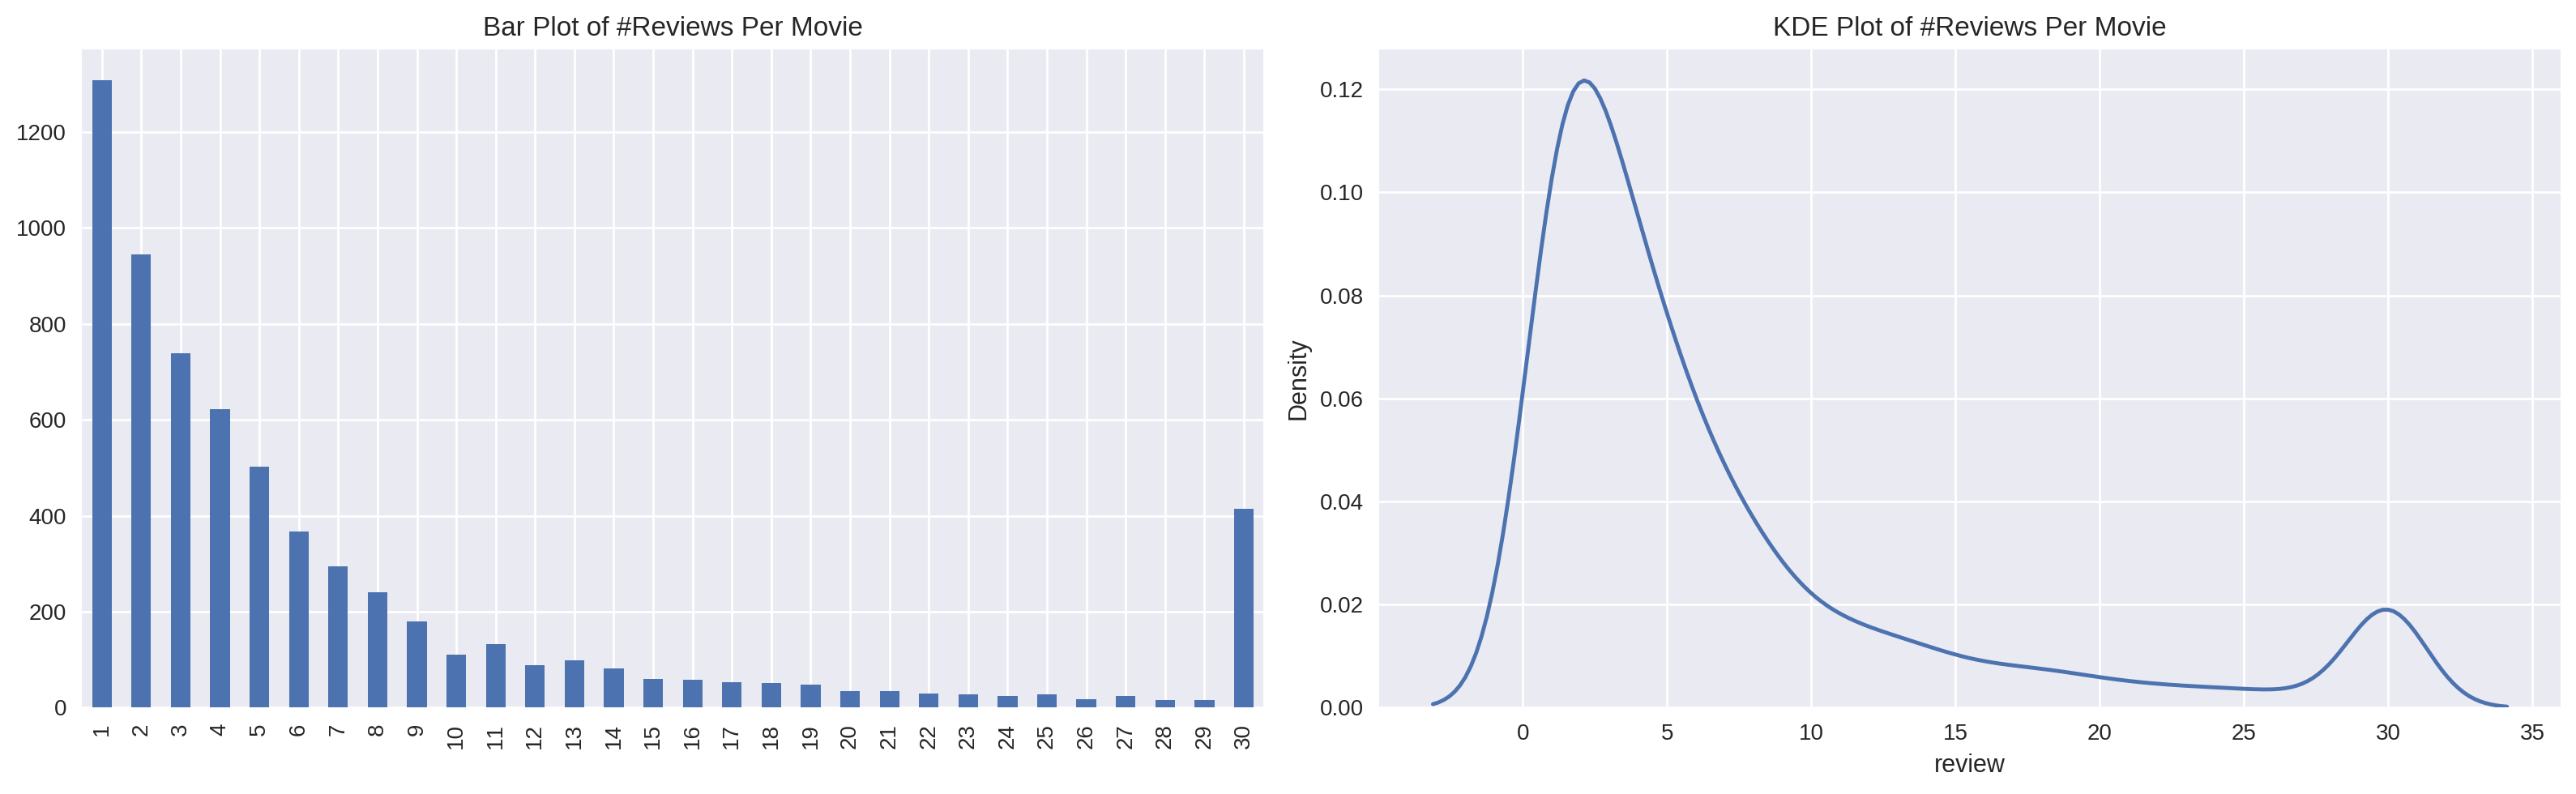

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

From these graphs, the majority of movies have a low number of reviews. Most movies fall into the bin of 1 for the total number of reviews, and the total number of movies tends to decrease with an increase number of reviews. The exception to this is movies with 30 reviews; these movies are some of the most popular ones represented in the DataFrame.

In [40]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

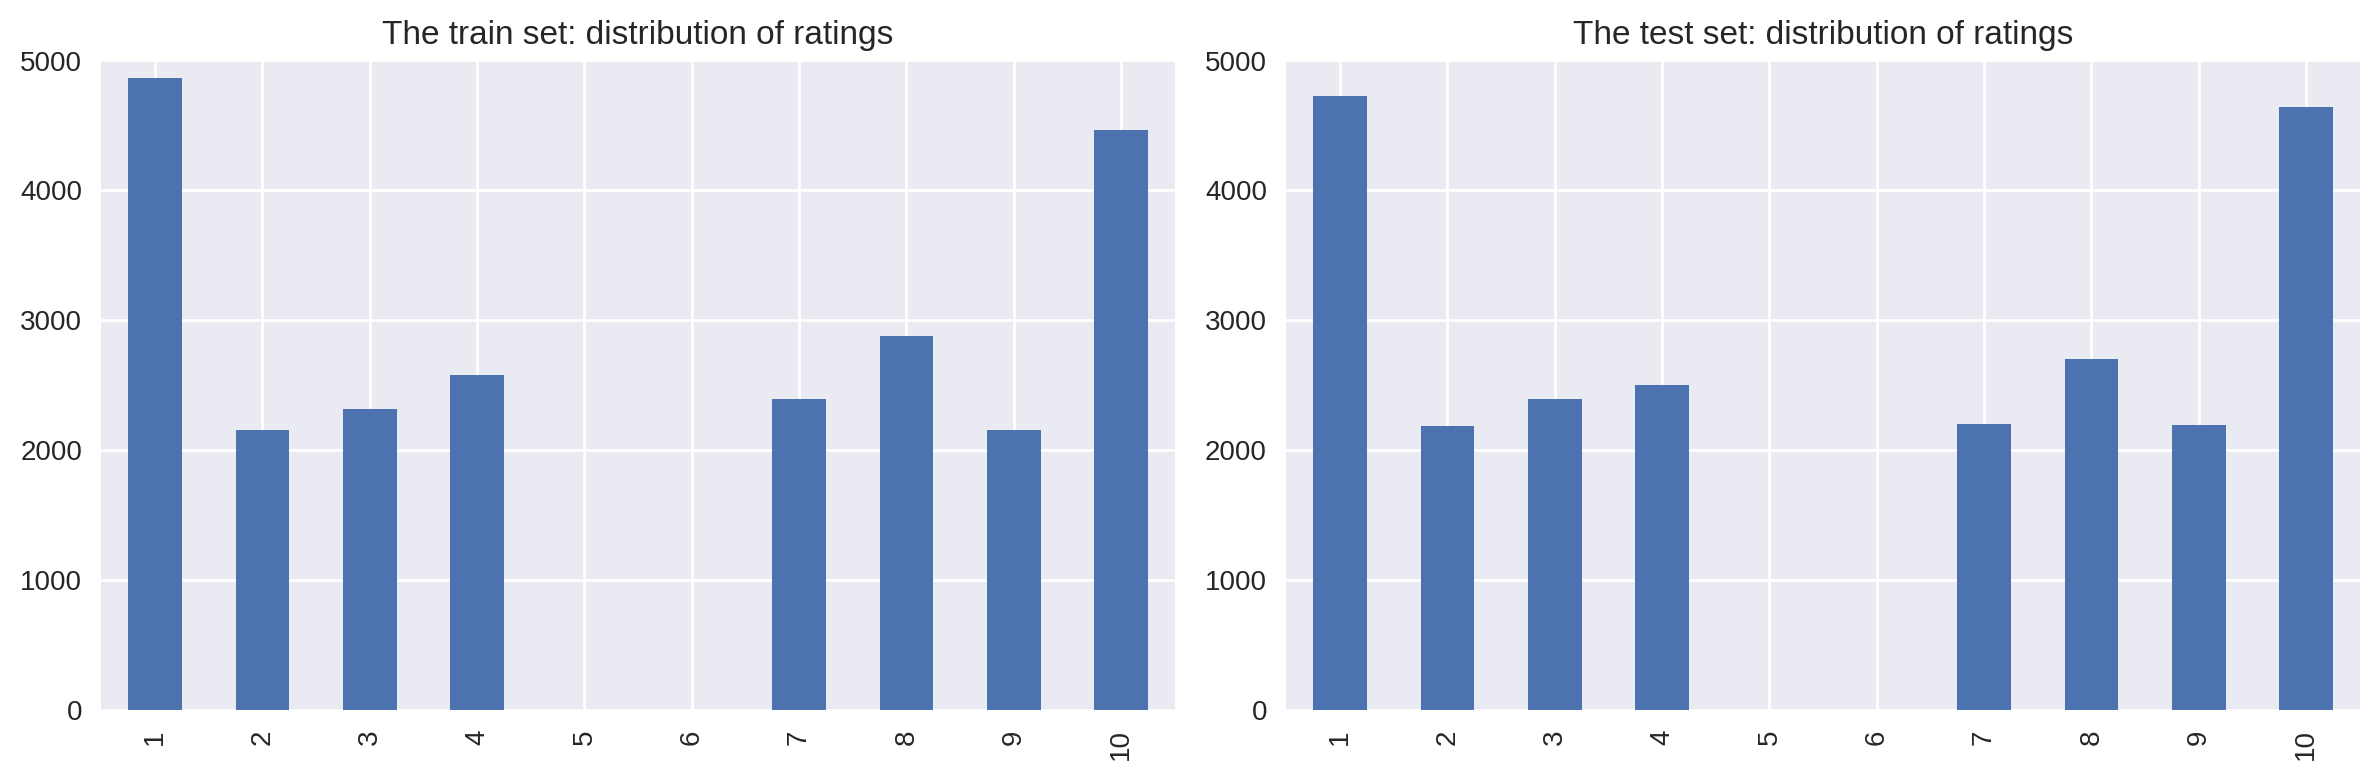

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distributions between sets are even between the sets. The reviews chosen appear to all have come from individuals who rated the relevant movies as between 1 and 4 or between 7 and 10; there are no reviews with ratings of 5 or 6 in this dataset. It may be good for building our models, but might affect the real-world accuracy of our model, as ratings of 5 or 6 might offer both positive and negative takes on the movie.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


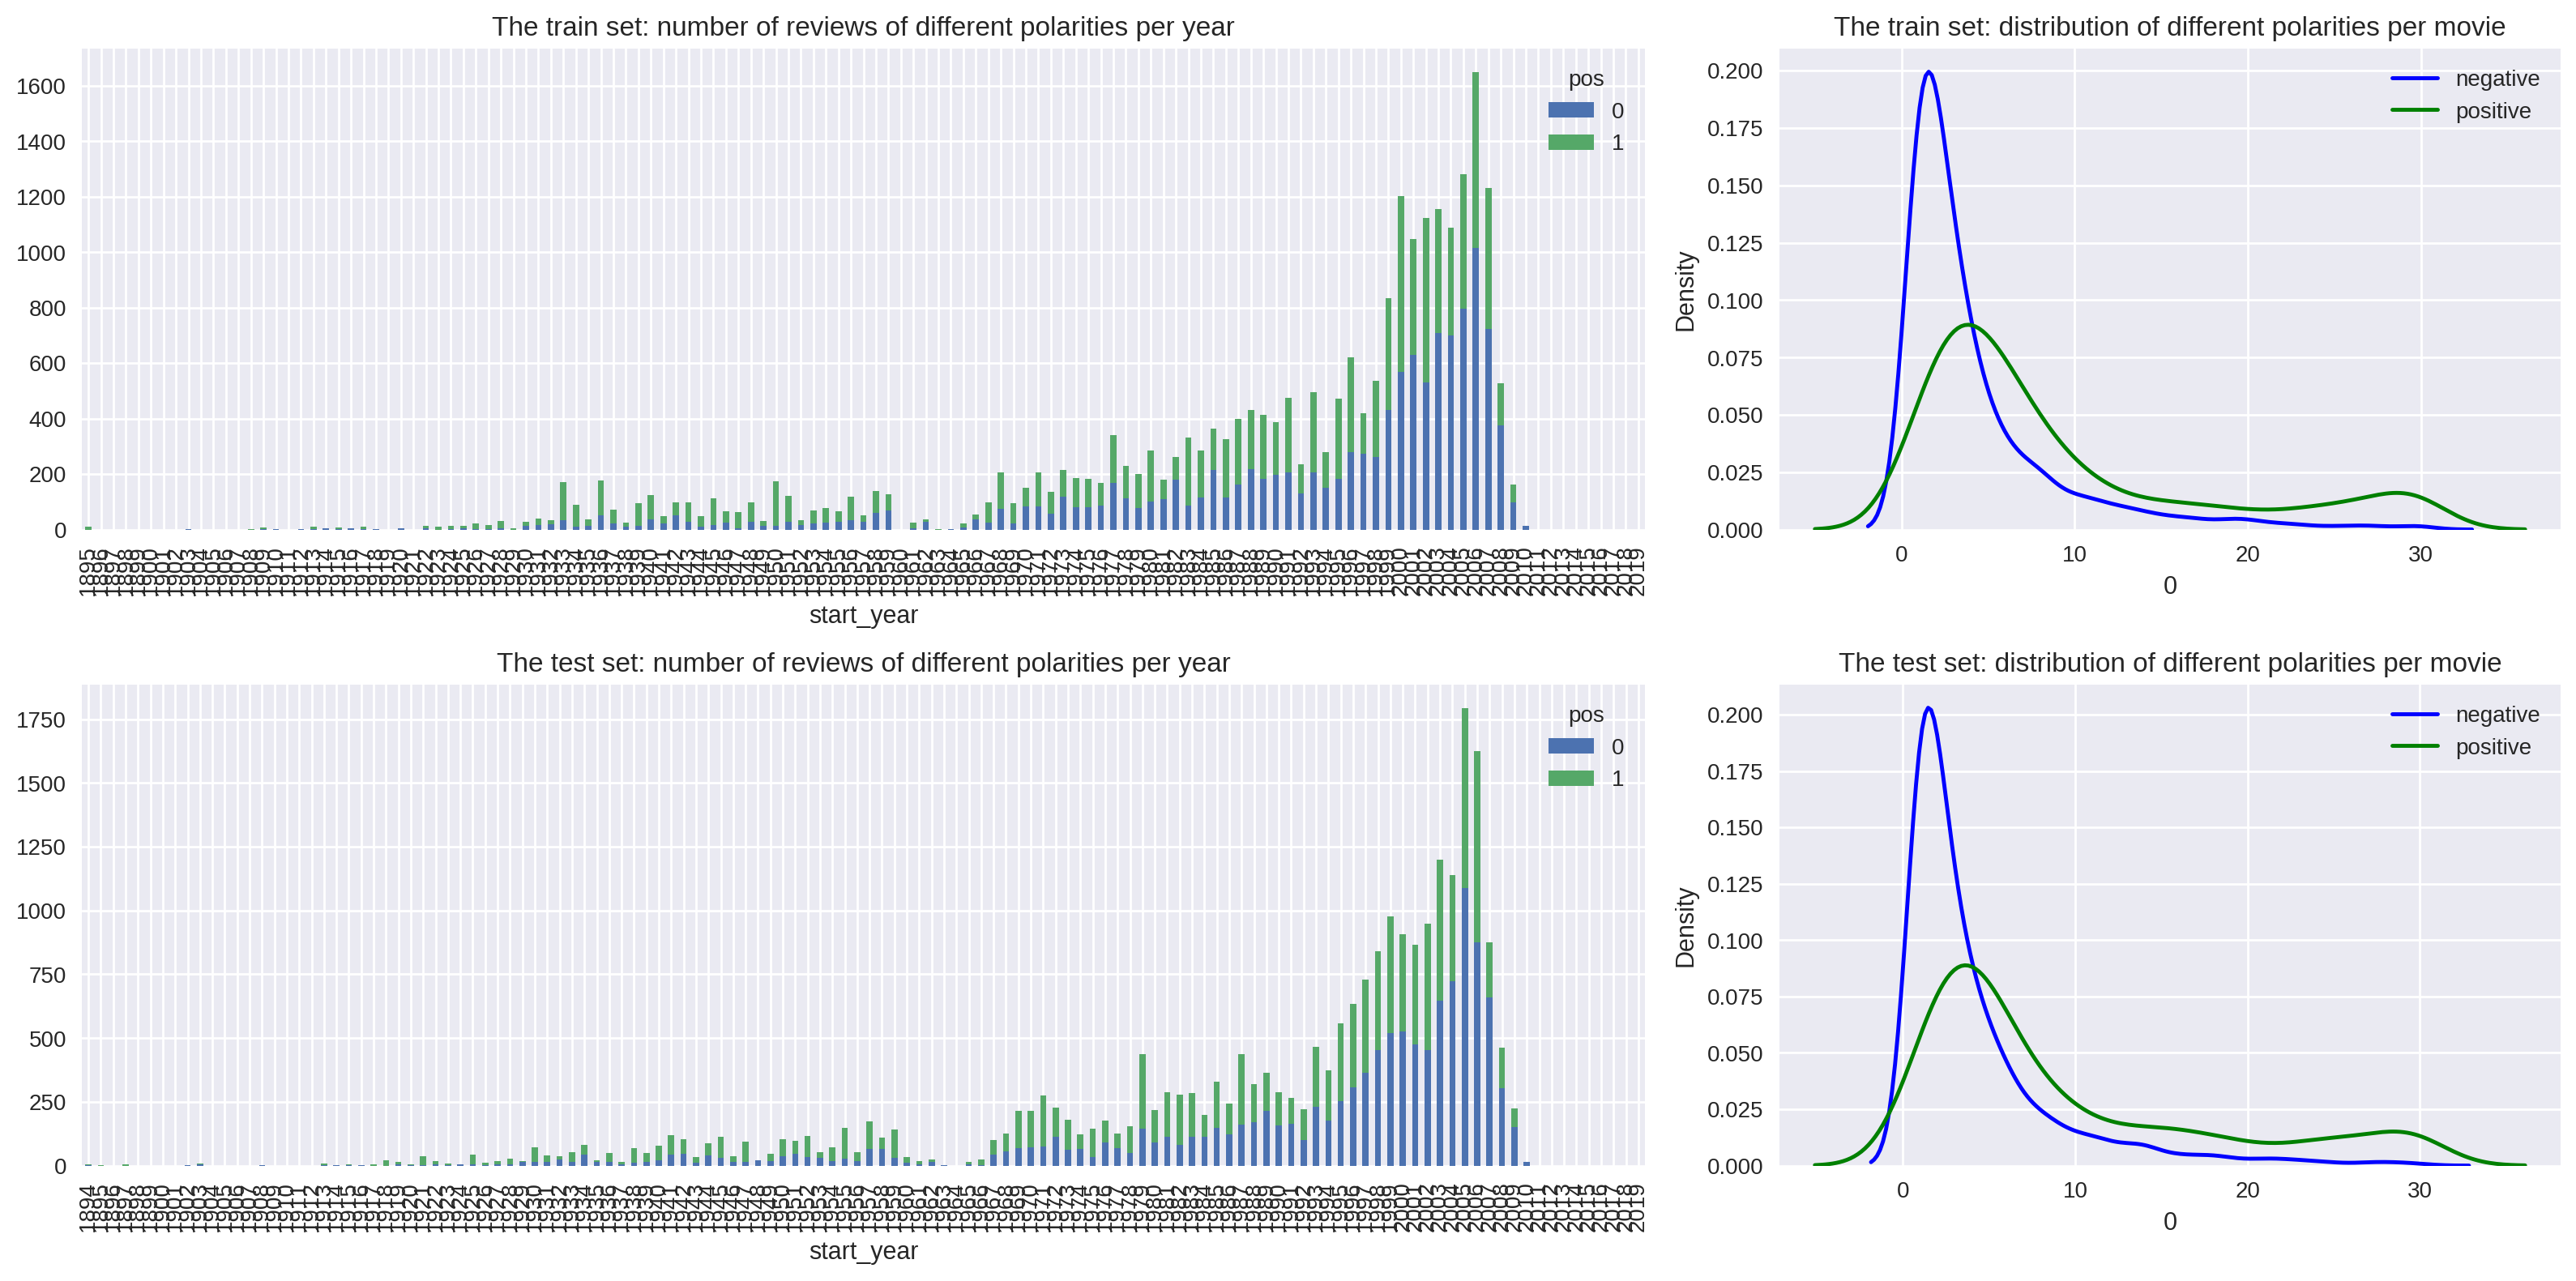

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Practically matching graphs. It is a good split between the train and test sets. From these plots we can see that the number of reviews made greatly increased over the last two decades. We see that there is a greater proportion of negative reviews for movies with fewer reviews than for those with a high-number of reviews. We see a similar pattern with positive reviews, though the probability of a review being positive is higher than the probability of it being negative for movies with 5 or more reviews. Overall, the distribution of reviews appears very similar for both training and testing datasets.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [43]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

This is a evaluation routine that can be used to evaluate all models we create. This function will obtain predictins from the models, as well as the predicted probabilities, and create ROC and PRC plots, as well as plot the F1 scores at various thresholds. It will also save the critical stats to a dictionary, which will be printed as a DataFrame.

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [44]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

In [45]:
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made   presenti...
2        there is no real story the film seems more lik...
3        um      a serious film about troubled teens in...
4        i m totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos  it sp...
47327    talk about being boring  i got this expecting ...
47328    i never thought i d say this about a biopic  b...
47329    spirit and chaos is an artistic biopic of miya...
47330    i ll make this brief  this was a joy to watch ...
Name: review_norm, Length: 47331, dtype: object

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [46]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [47]:
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

## Working with models

In this section, we will build and evaluate different classification models with the goal of building one that predicts whether a review is positive or negative with an F1 score greater than .85. To evaluate the models, we will be using the 'evaluate_model' function we developed earlier.

### Model 0 - Constant

In [48]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


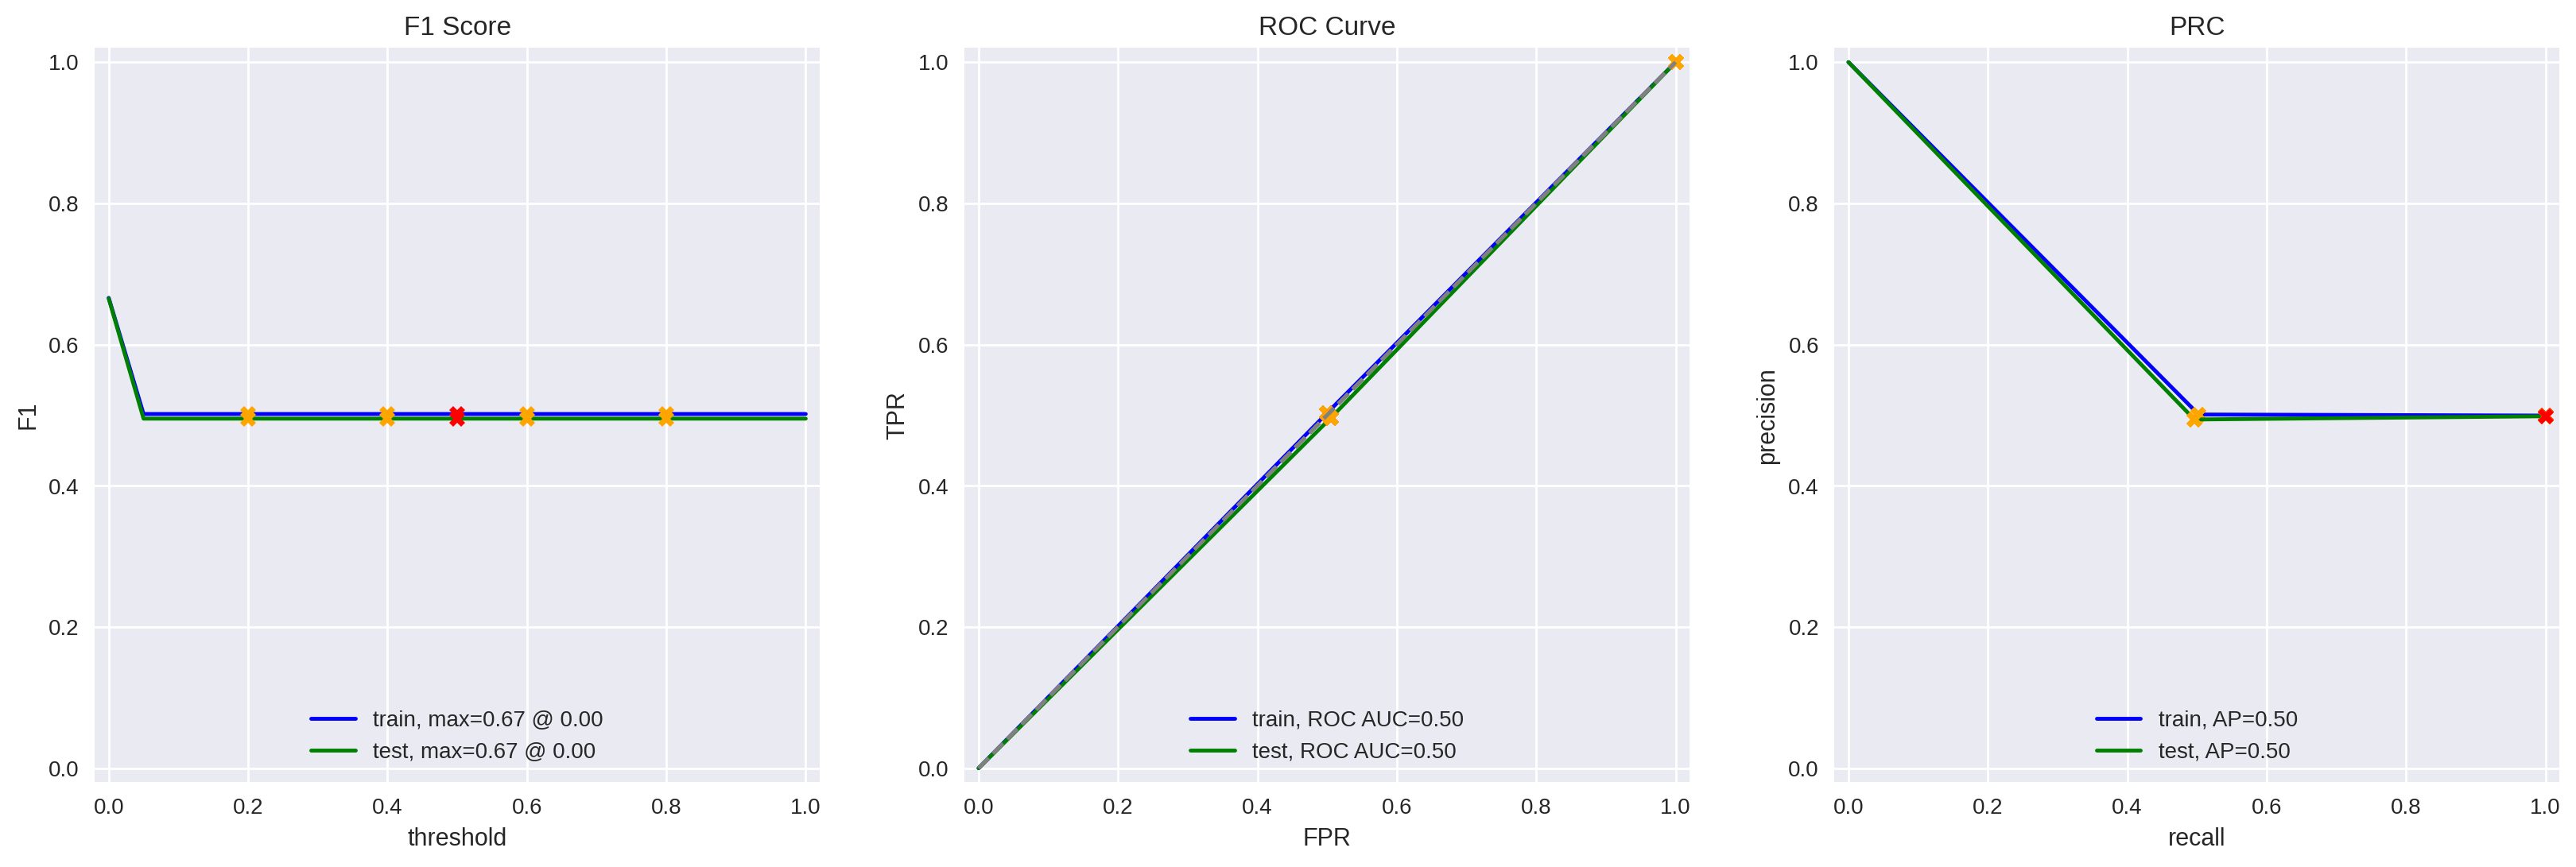

In [49]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=12345)
dummy_clf.fit(train_features, train_target)
evaluate_model(dummy_clf, train_features, train_target, test_features, test_target)

The dummy model predicted the correct answers with an .5 accuracy score in both the training and testing sets. The F1, APS, and AUC-ROC scores were also .5. These scored indicate that our dummy model classifies observations in such a manner that is no better than chance. This model will serve as one benchmark for determining how well our later models perform.

### Model 1 - NLTK, TF-IDF and LR

Here is a logistic regression model with tf-idf vectorized reviews.Prior to vectorization, we will use NLTK's WordNetLemmatizer to lemmatize the reviews in the sets.

In [50]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
CPU times: user 6.07 s, sys: 3.45 s, total: 9.52 s
Wall time: 9.53 s


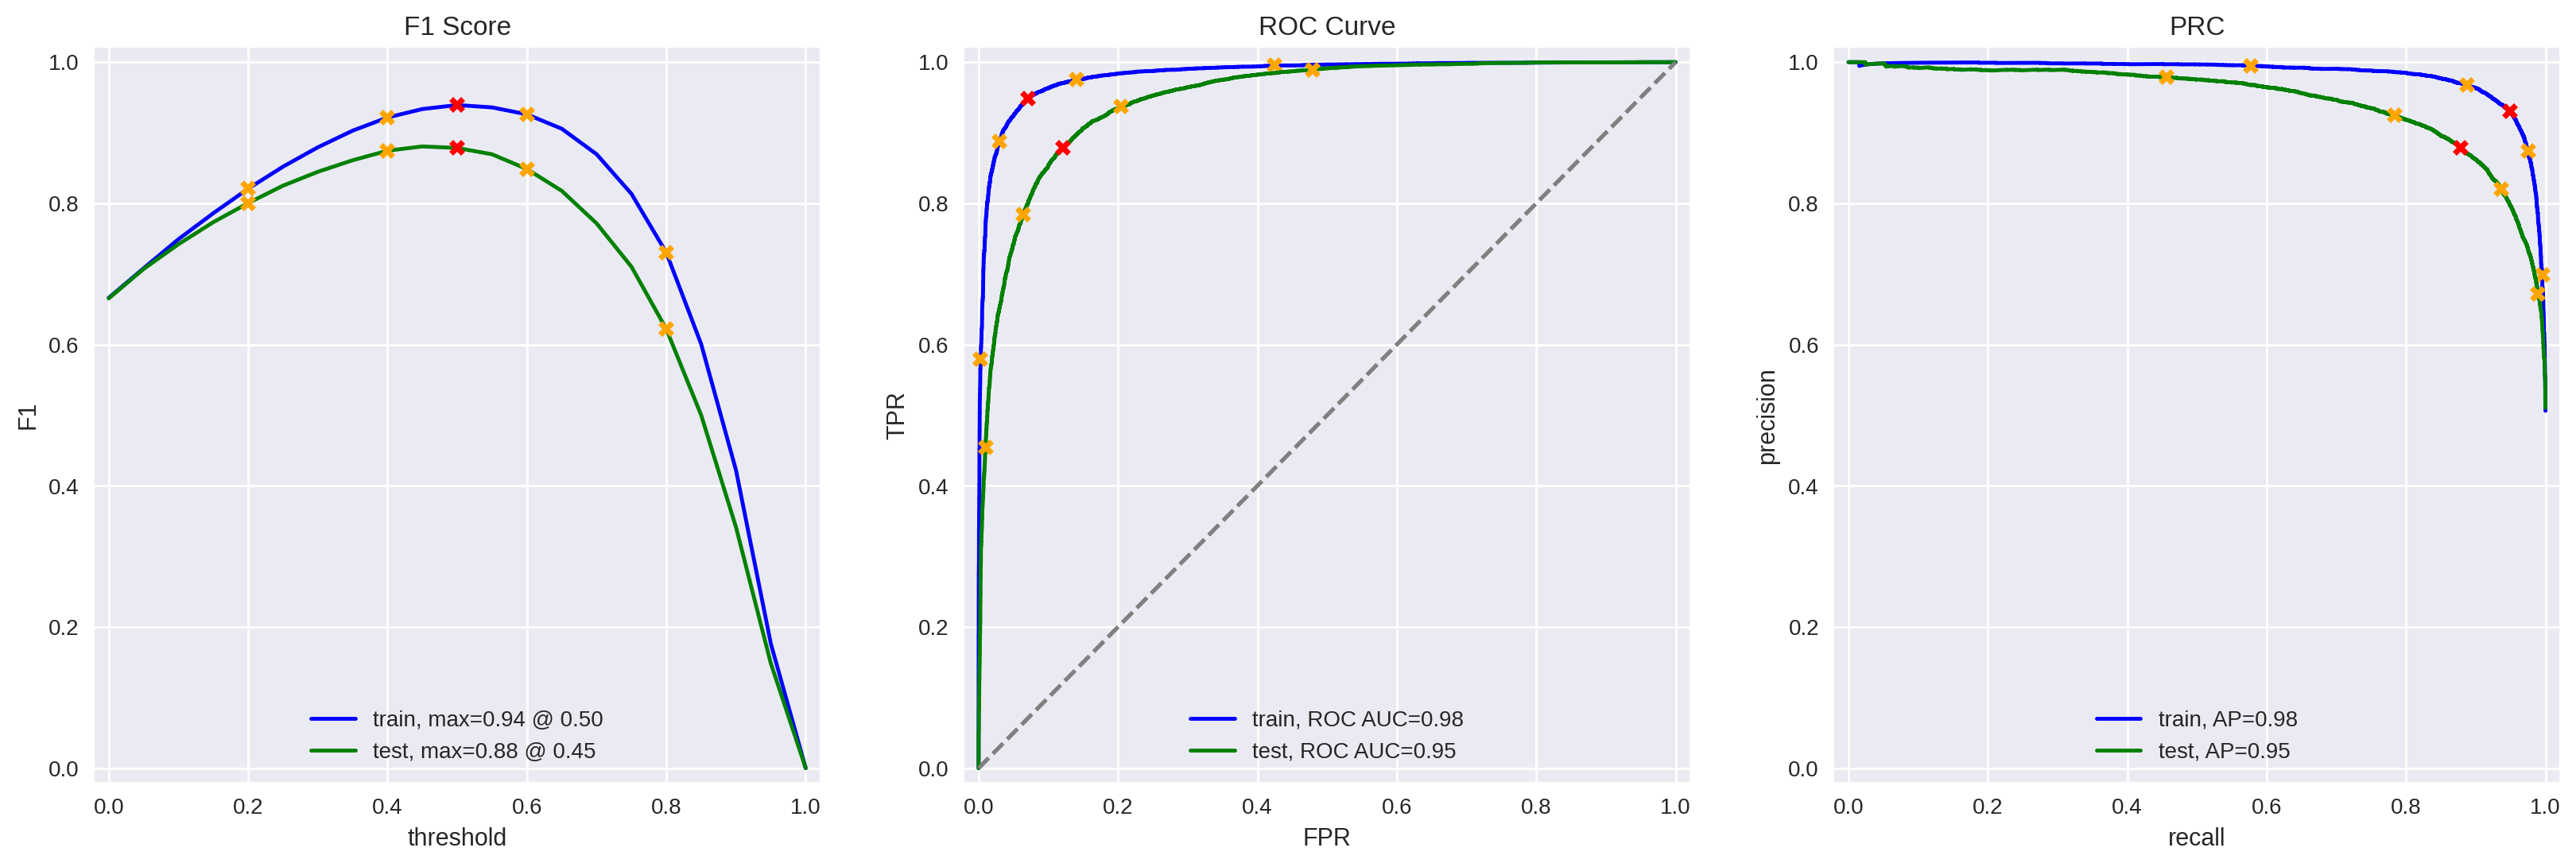

In [51]:
%%time
# Create a TF-IDF vectorizer
vectorizer_1 = TfidfVectorizer(stop_words='english')

# Fit the vectorizer to the text data and transform it into TF-IDF features
X_train = vectorizer_1.fit_transform(train_features)
y_train = train_target

X_test = vectorizer_1.transform(test_features)

model_1 = LogisticRegression(random_state=12345)
model_1.fit(X_train,y_train)
evaluate_model(model_1, X_train, y_train, X_test, test_target)

The logistic regression model performed much better than the dummy model. The model has a near-perfect average precision score as well as AUC ROC score. The F1 score for the training set was higher than the testing set. The test set still produced a score of .88, which is higher than the minimum score specified by the company (.85).

### Model 2 - spaCy, TF-IDF and LR

Similar to the first model except that we will use spaCy to lemmatize the words for the reviews. We will then vectorize the words according to TF-IDF and create, train, and test a linear regression model.

In [52]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [53]:
%%time
def text_preprocessing_2(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

train_features_2= train_features.apply(text_preprocessing_2)
test_features_2= test_features.apply(text_preprocessing_2)

CPU times: user 8min 19s, sys: 105 ms, total: 8min 19s
Wall time: 8min 20s


          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95
CPU times: user 4.72 s, sys: 1.79 s, total: 6.52 s
Wall time: 6.52 s


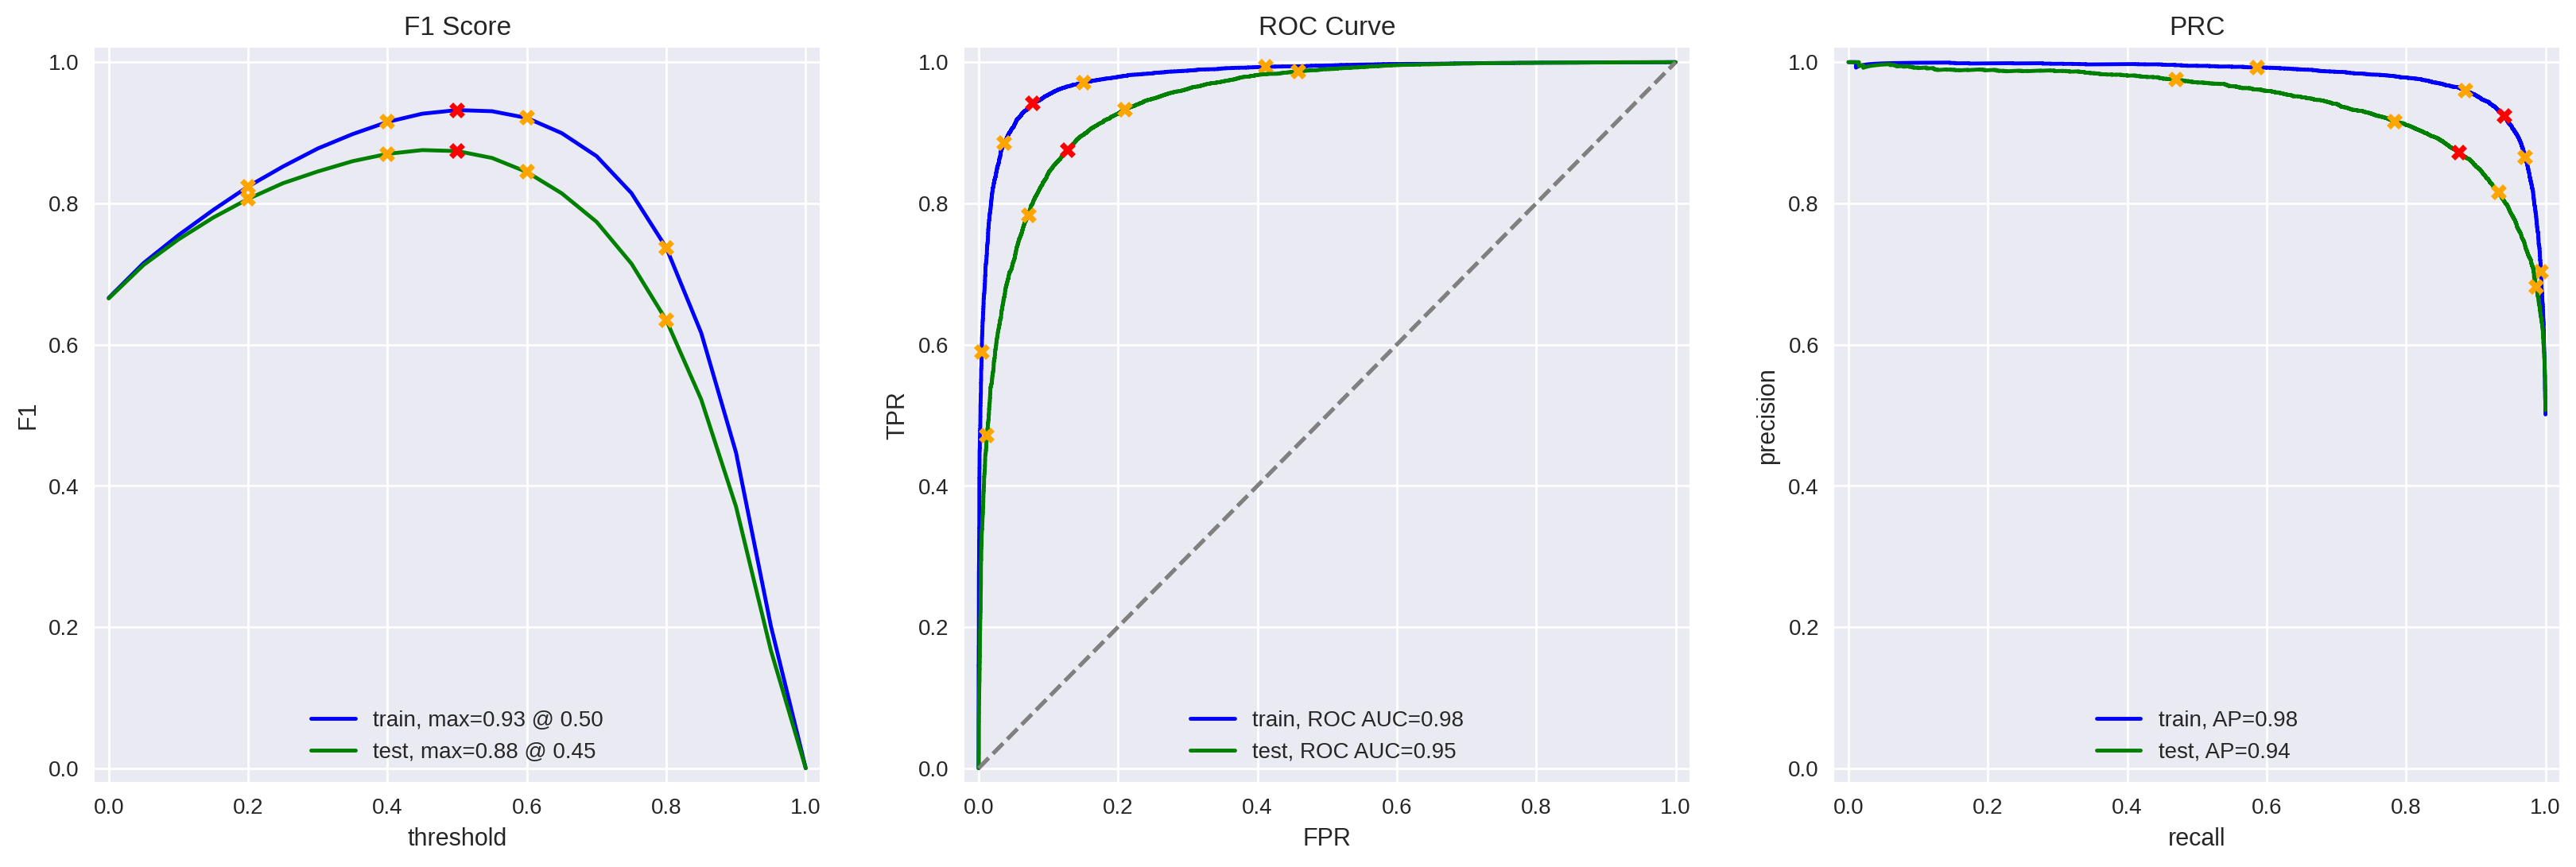

In [54]:
%%time
# Create a TF-IDF vectorizer
vectorizer_2 = TfidfVectorizer(stop_words='english')

# Fit the vectorizer to the text data and transform it into TF-IDF features
X_train = vectorizer_2.fit_transform(train_features_2)
y_train = train_target

X_test = vectorizer_2.transform(test_features_2)

model_2 = LogisticRegression(random_state=12345)
model_2.fit(X_train,y_train)
evaluate_model(model_2, X_train, y_train, X_test, test_target)

The logistic regression model, when tokenized using spaCy, provides slightly lower accuracy and F1 scores than the same model where we tokenized reviews using NLTK. The differences in the scores between the models is approxomately .01 points for each metric or the same. This model meets the minimum-score criteria specified by the Film Junky Union.

### Model 3 - spaCy, TF-IDF and LGBMClassifier

Testingt whether a LGBM Classifier would offer a higher F1 score than our previous models, using spaCy to tokenize/lemmatize and vectorized according to TF-IDF.

In [55]:
from lightgbm import LGBMClassifier

In [56]:
%%time
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

train_features_3 = train_features.apply(text_preprocessing_3)
test_features_3 = test_features.apply(text_preprocessing_3)

CPU times: user 8min 4s, sys: 86.4 ms, total: 8min 4s
Wall time: 8min 5s


          train  test
Accuracy   0.91  0.85
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93
CPU times: user 33.7 s, sys: 43.8 ms, total: 33.7 s
Wall time: 33.7 s


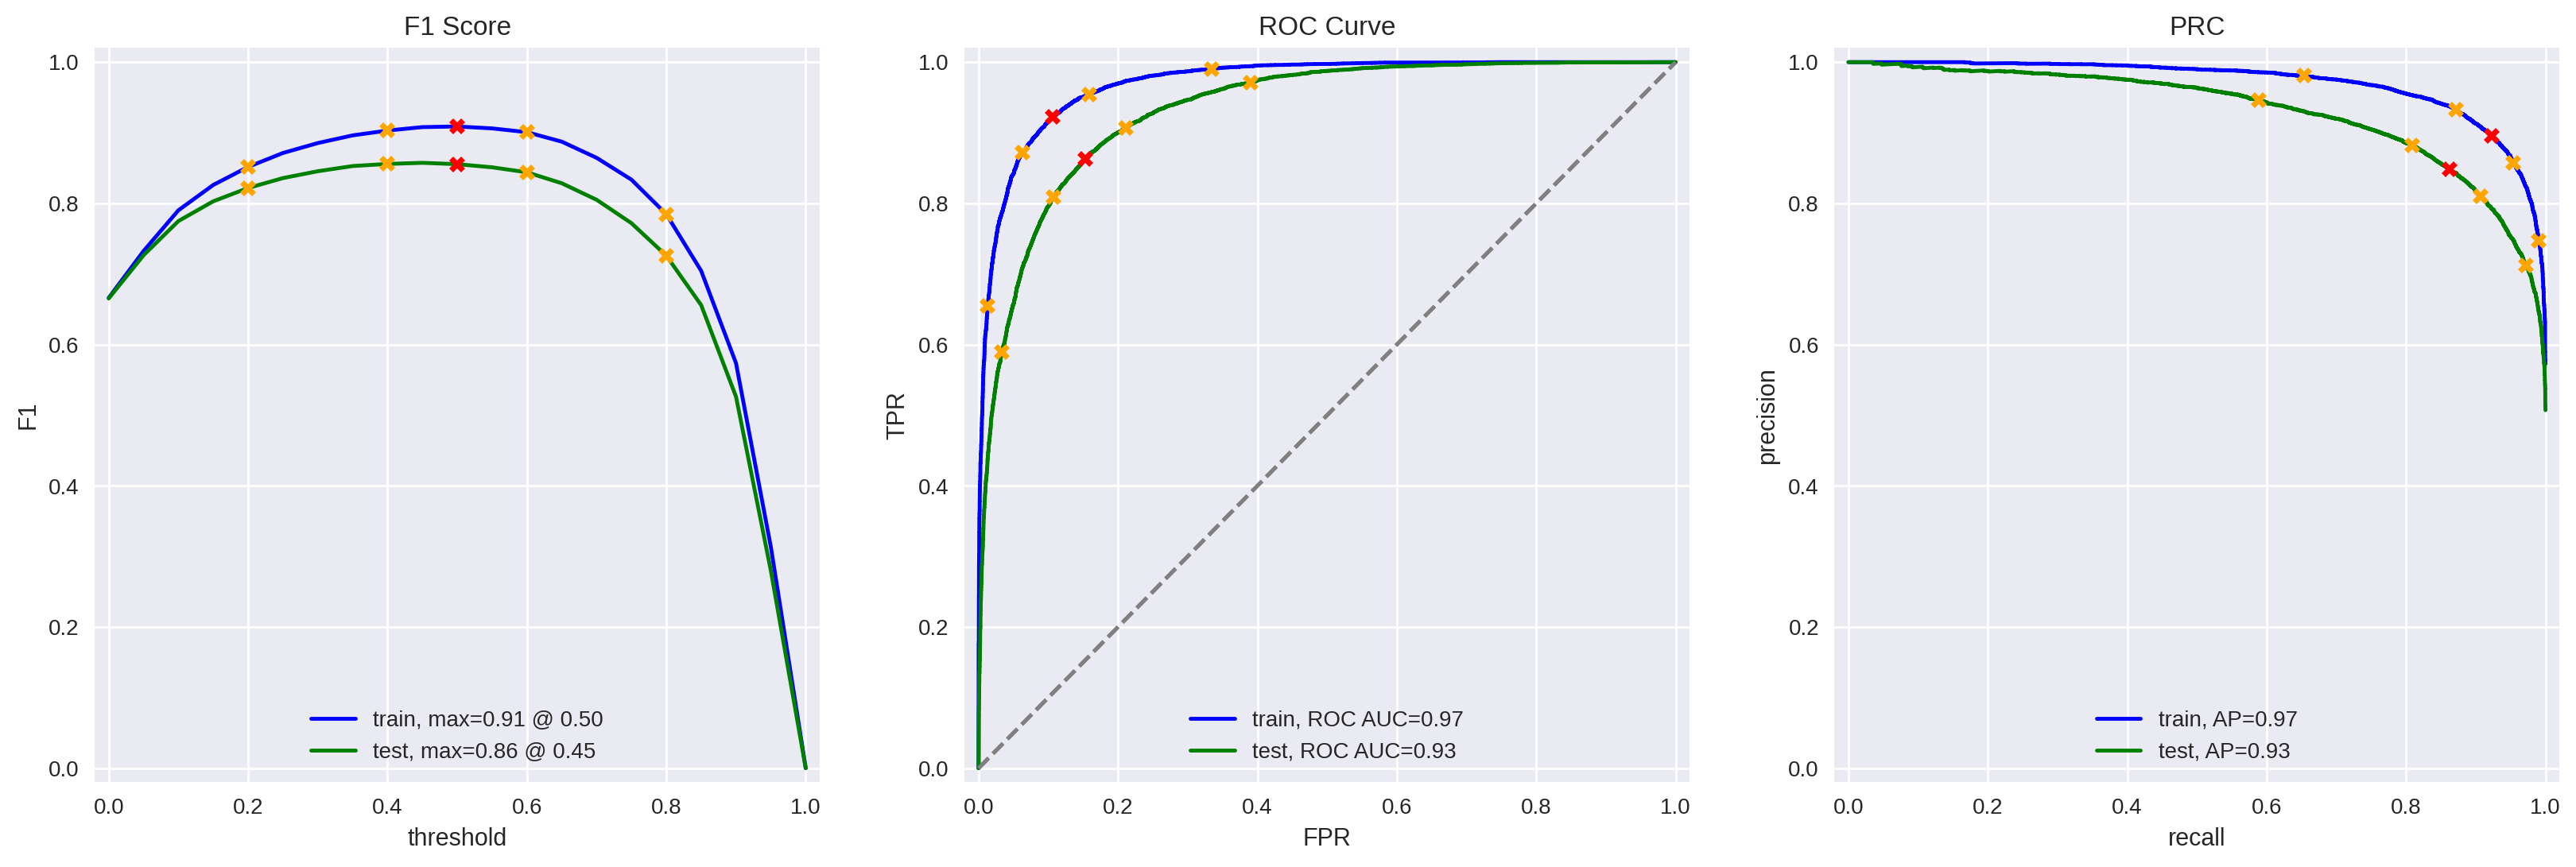

In [57]:
%%time
vectorizer_3 = TfidfVectorizer(stop_words='english')

# Fit the vectorizer to the text data and transform it into TF-IDF features
X_train = vectorizer_3.fit_transform(train_features_3)
y_train = train_target

X_test = vectorizer_3.transform(test_features_3)

model_3 = LGBMClassifier(random_state=12345)
model_3.fit(X_train, y_train)
evaluate_model(model_3, X_train, y_train, X_test, test_target)

The LGBMClassifier does not perform as well as our previous model. Using the same dataset, the Logistic Regression model provided higher scores for each metric compared to LGBM Classifier model. The model's F1 score for the testing dataset is .86, which mean that it meets the Film Junky Union's minimum threshold score for a review classification model.

## Model Findings

I trained various models using diffrent NLP methods for converting text into vectors. Among the methods is tokenization using NLTK, spaCy, and BERT(computation wasnt possible on my local device), as well as vectorization using TF-IDF. Overall, we found that model 1, which uses a combination of NLTK, TF-IDF and logistic regression, provided the highest F1 score of .88 for the training datasets . The other models provided slightly lower scores(Model 2 F1 score:.87 and Model 3 F1 score:.86). Model 1 provids the best F1 score is a positive sign because it took a short time to run compared to other models. 

## My Reviews

Below is testing of our models using reviews that we've written. We will construct the reviews so there is an equal class balance between positive and negative reviews. After converting our texts into the relevant format, we get predictions from the models.

In [32]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

#Add column to reviews to indicate whether reviews are positive or negative.
my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1]

my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

my_reviews

,review,pos,review_norm
0,"I did not simply like it, not my kind of movie.",0,i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",0,well i was bored and felt asleep in the middl...
2,I was really fascinated with the movie,1,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,0,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,1,i didn t expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",1,the movie had its upsides and downsides but i...
6,What a rotten attempt at a comedy. Not a singl...,0,what a rotten attempt at a comedy not a singl...
7,Launching on Netflix was a brave move & I real...,1,launching on netflix was a brave move i real...


### Model 1 - NLTK, TF-IDF, LR

In [33]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review[:50]}')

Actual: 0 | Predicted: 0 | Text: i did not simply like it  not my kind of movie 
Actual: 0 | Predicted: 0 | Text: well  i was bored and felt asleep in the middle of
Actual: 1 | Predicted: 1 | Text: i was really fascinated with the movie
Actual: 0 | Predicted: 0 | Text: even the actors looked really old and disintereste
Actual: 1 | Predicted: 0 | Text: i didn t expect the reboot to be so good  writers 
Actual: 1 | Predicted: 0 | Text: the movie had its upsides and downsides  but i fee
Actual: 0 | Predicted: 0 | Text: what a rotten attempt at a comedy  not a single jo
Actual: 1 | Predicted: 1 | Text: launching on netflix was a brave move   i really a


6/8 were accurately predicted with Model 1.

### Model 2 - spaCy, TF-IDF, LR

In [34]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review[:50]}')

Actual: 0 | Predicted: 0 | Text: i did not simply like it  not my kind of movie 
Actual: 0 | Predicted: 0 | Text: well  i was bored and felt asleep in the middle of
Actual: 1 | Predicted: 1 | Text: i was really fascinated with the movie
Actual: 0 | Predicted: 0 | Text: even the actors looked really old and disintereste
Actual: 1 | Predicted: 0 | Text: i didn t expect the reboot to be so good  writers 
Actual: 1 | Predicted: 0 | Text: the movie had its upsides and downsides  but i fee
Actual: 0 | Predicted: 0 | Text: what a rotten attempt at a comedy  not a single jo
Actual: 1 | Predicted: 1 | Text: launching on netflix was a brave move   i really a


6/8 were accurately predicted with Model 2.

### Model 3 - spaCy, TF-IDF, LGBMClassifer

In [35]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review[:50]}')

Actual: 0 | Predicted: 1 | Text: i did not simply like it  not my kind of movie 
Actual: 0 | Predicted: 0 | Text: well  i was bored and felt asleep in the middle of
Actual: 1 | Predicted: 1 | Text: i was really fascinated with the movie
Actual: 0 | Predicted: 0 | Text: even the actors looked really old and disintereste
Actual: 1 | Predicted: 1 | Text: i didn t expect the reboot to be so good  writers 
Actual: 1 | Predicted: 1 | Text: the movie had its upsides and downsides  but i fee
Actual: 0 | Predicted: 0 | Text: what a rotten attempt at a comedy  not a single jo
Actual: 1 | Predicted: 1 | Text: launching on netflix was a brave move   i really a


7/8 were accurately predicted with Model 3. 

Testing of each model for reviews we wrote ourselves. Model 1 and model 2 both scored 6/8 while model 3, got 7/8 correct. misclassification of one review which was flagged positive when the actual sentiment was negative.

## Conclusions

For this project it was asked to develop a ML model that classifies movie reviews as positive or negative. We preprocessed the data and normalized it by lower caseing,  and replaceing non letters with spaces. In the exploratory data analysis, it was found that there are nearly an equal number of positive and negative reviews in the dataset, as well as identical equal distribution of movie ratings in each dataset. We buiuld various models and tested them after lemmatization and tokenization processes, then vectorization of the words according to TF-IDF. Having acore of .85 was asked and Models 1,2 and 3 scored .88,.87, .86 respectively, achieveing this target. The constant was a dummy model which scored .5 for its F1 score.

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions

###  Model 9 - BERT

In the following subsection, we will train and test a BERT model to accurately classify the reviews.

When trying to running the BERT model, ran into an error. I have an AMD graphics card and using cuda requires an NVIDIA GPU. Ihe CPU crashes the kernel. It should run on a NVIDIA GPU.

In [58]:
import torch
import transformers

In [59]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [60]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    # <put your code here to create ids_list and attention_mask_list>
    for text in texts:
        inputs = tokenizer.encode_plus(
            text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        ids_list.append(inputs['input_ids'].squeeze().tolist())
        attention_mask_list.append(inputs['attention_mask'].squeeze())
    
    
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
        attention_mask_batch = torch.stack(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
%%time
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'])

Using the cpu device.


  0%|          | 0/238 [00:00<?, ?it/s]

In [1]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

NameError: name 'df_reviews_train' is not defined

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

### Model 9 - BERT

In [36]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review[:50]}')

SyntaxError: invalid syntax (423769328.py, line 8)